In [96]:
from resemblyzer import preprocess_wav, VoiceEncoder
from tqdm import tqdm

In [1]:
import numpy as np

import joblib

import re

import pandas as pd

import seaborn as sns

from collections import Counter

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, f1_score, classification_report 

In [2]:
data = np.load('../Downloads/gender_data.npz')

In [3]:
data.files

['embeds', 'file_paths', 'gender', 'duration']

In [4]:
embeddings, duration, labels, paths = data['embeds'], data['duration'], data['gender'], data['file_paths']

In [5]:
embeddings.shape, duration.shape, labels.shape, paths.shape

((32122, 256), (32122,), (32122,), (32122,))

In [6]:
print(f"Total duration of data : {np.sum(duration)//3600} hours")

Total duration of data : 47.0 hours


In [7]:
source_name = [p.split('/')[-5] for p in paths]

In [8]:
set(source_name)

{'bucket_data', 'openslr_kn', 'openslr_ta', 'openslr_te', 'tarini', 'youtube'}

In [9]:
embeddings = embeddings.astype('float16')

In [10]:
labels = np.where(labels=='male', 0, labels)
labels = np.where(labels=='female', 1, labels)

In [11]:
labels = labels.astype('int16')

In [12]:
data_df = pd.DataFrame()

In [13]:
for i in range(256):
    data_df['feature_'+str(i)] = embeddings[:,i]

In [14]:
data_df.shape

(32122, 256)

In [15]:
data_df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,0.122986,0.0,0.172363,0.0,0.000000,0.0,0.082214,0.070557,0.041473,0.000000,...,0.135132,0.0,0.069702,0.00000,0.0,0.041168,0.000000,0.0,0.073486,0.0
1,0.052094,0.0,0.055695,0.0,0.002235,0.0,0.000000,0.006420,0.042542,0.008408,...,0.011482,0.0,0.110046,0.03244,0.0,0.025604,0.168945,0.0,0.018845,0.0


In [16]:
data_df.insert(loc=0, column='labels', value=labels)
data_df.insert(loc=1, column='duration', value=duration)
data_df.insert(loc=2, column='source_name', value=source_name)
data_df.insert(loc=3,column='file_paths', value=paths)

In [17]:
data_df.shape

(32122, 260)

In [18]:
data_df.head(2)

,labels,duration,source_name,file_paths,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,0,2.133313,openslr_kn,/Users/neerajchhimwal/ekstep-speech-recognitio...,0.122986,0.0,0.172363,0.0,0.000000,0.0,...,0.135132,0.0,0.069702,0.00000,0.0,0.041168,0.000000,0.0,0.073486,0.0
1,0,10.240000,openslr_kn,/Users/neerajchhimwal/ekstep-speech-recognitio...,0.052094,0.0,0.055695,0.0,0.002235,0.0,...,0.011482,0.0,0.110046,0.03244,0.0,0.025604,0.168945,0.0,0.018845,0.0


<AxesSubplot:xlabel='duration', ylabel='Count'>

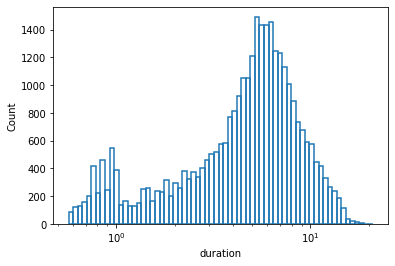

In [19]:
sns.histplot(data_df.duration, log_scale=True, fill=False)

In [20]:
# data_df[data_df.duration<=2].shape

In [21]:
# data_v1 = data_df[~(data_df.duration<=2)]
data_v1 = data_df.copy()
data_v1.shape

(32122, 260)

In [22]:
# sns.histplot(data_v1.duration, log_scale=True, fill=False)

In [23]:
print(f"Total duration of data after removing utterances less than 2 sec : {np.sum(data_v1.duration)//3600} hours")

Total duration of data after removing utterances less than 2 sec : 47.0 hours


In [24]:
data_v1.groupby(['source_name'])['duration'].agg('sum')//3600

source_name
bucket_data     3.0
openslr_kn      3.0
openslr_ta      3.0
openslr_te      2.0
tarini         20.0
youtube        13.0
Name: duration, dtype: float64

In [25]:
## test on youtube and train on rest of the data

In [26]:
data_v1.source_name.unique()

array(['openslr_kn', 'bucket_data', 'openslr_ta', 'youtube', 'tarini',
       'openslr_te'], dtype=object)

In [27]:
X_train = data_v1[~(data_v1.source_name=='youtube')].drop(['labels', 'source_name', 'file_paths', 'duration'], axis=1).values
y_train = data_v1[~(data_v1.source_name=='youtube')]['labels'].values

In [28]:
X_train.shape, y_train.shape

((21488, 256), (21488,))

In [29]:
train_indexes = data_v1[~(data_v1.source_name=='youtube')].index

In [30]:
data_v1[(data_v1.source_name=='youtube')]['labels'].value_counts()

0    7942
1    2692
Name: labels, dtype: int64

In [31]:
youtube_female = data_v1[(data_v1.source_name=='youtube') & (data_v1.labels==1)].reset_index(drop=True)

In [32]:
youtube_male = data_v1[(data_v1.source_name=='youtube') & (data_v1.labels==0)].reset_index(drop=True)

In [33]:
np.random.seed(2020)

In [34]:
youtube_male_50 = youtube_male.loc[np.random.choice(youtube_male.index, 2692, replace=False)]
test_50 = pd.concat([youtube_male_50, youtube_female]).reset_index(drop=True)

In [35]:
youtube_male_25 = youtube_male.loc[np.random.choice(youtube_male.index, 897, replace=False)]
test_25 = pd.concat([youtube_male_25, youtube_female]).reset_index(drop=True)

In [36]:
test_75 = pd.concat([youtube_male, youtube_female]).reset_index(drop=True)

In [37]:
skFold = StratifiedKFold(n_splits=5, shuffle=False, random_state=2020)

/Users/ankurdhuriya/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [38]:
%%time

cv_scores = []
for train_ix, val_ix in tqdm(skFold.split(X_train, y_train)):
    
    train_X, val_X = X_train[train_ix], X_train[val_ix]
    train_y, val_y = y_train[train_ix], y_train[val_ix]
    #model
    clf_SVC = SVC(kernel='rbf', gamma=0.01, C=100, random_state=2020, probability=True) 
    #fit
    clf_SVC.fit(train_X, train_y)
    #predict
    pred = clf_SVC.predict(val_X)
    pred_proba = clf_SVC.predict_proba(val_X)
    cv_scores.append(f1_score(val_y, pred))

5it [01:55, 23.18s/it]

CPU times: user 1min 55s, sys: 242 ms, total: 1min 55s
Wall time: 1min 55s


In [87]:
def save_model(model, filename):
    joblib.dump(model, filename)

In [88]:
def load_model(filename):
    return joblib.load(filename)

In [89]:
save_model(clf_SVC, filename='clf_svc.sav')

In [39]:
print(f"F1 Score on validation : {np.mean(cv_scores)} +/- {np.std(cv_scores)}")

F1 Score on validation : 0.9846072026809803 +/- 0.012771463760817241


In [40]:
X_test_25 = test_25.drop(['labels', 'source_name', 'file_paths', 'duration'], axis=1).values
y_test_25 = test_25['labels'].values

In [41]:
y_pred_25 = clf_SVC.predict(X_test_25)

confusion_matrix(y_test_25, y_pred_25)

array([[ 864,   33],
       [ 147, 2545]])

In [42]:
print(classification_report(y_test_25, y_pred_25))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91       897
           1       0.99      0.95      0.97      2692

    accuracy                           0.95      3589
   macro avg       0.92      0.95      0.94      3589
weighted avg       0.95      0.95      0.95      3589



In [43]:
X_test_50 = test_50.drop(['labels', 'source_name', 'file_paths', 'duration'], axis=1).values
y_test_50 = test_50['labels'].values

In [44]:
y_pred_50 = clf_SVC.predict(X_test_50)

confusion_matrix(y_test_50, y_pred_50)

array([[2608,   84],
       [ 147, 2545]])

In [45]:
print(classification_report(y_test_50, y_pred_50))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2692
           1       0.97      0.95      0.96      2692

    accuracy                           0.96      5384
   macro avg       0.96      0.96      0.96      5384
weighted avg       0.96      0.96      0.96      5384



In [46]:
X_test_75 = test_75.drop(['labels', 'source_name', 'file_paths', 'duration'], axis=1).values
y_test_75 = test_75['labels'].values

In [47]:
y_pred_75 = clf_SVC.predict(X_test_75)

confusion_matrix(y_test_75, y_pred_75)

array([[7715,  227],
       [ 147, 2545]])

In [48]:
print(classification_report(y_test_75, y_pred_75))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7942
           1       0.92      0.95      0.93      2692

    accuracy                           0.96     10634
   macro avg       0.95      0.96      0.95     10634
weighted avg       0.97      0.96      0.96     10634



In [50]:
f = open('wrong_predictions.csv', mode='w+')
print("file_path,predicted_label,correct_label", file=f)
for row_index, (prediction, label) in enumerate(zip (y_pred_75, y_test_75)):
    if prediction != label:
        print(test_75.loc[row_index]['file_paths'],prediction,label,sep=",",file=f)
#         print('Path', test_75.loc[row_index]['file_paths'], 'has been classified as ', prediction, 'and should be ', label)
#         print()

In [51]:
set(["https://www.youtube.com/watch?v="+re.search("-id(.*).wav", i).group(1) for i in pd.read_csv('wrong_predictions.csv')['file_path'].values])

{'https://www.youtube.com/watch?v=0pN2QCH3Nmg',
 'https://www.youtube.com/watch?v=1w5wcE-KozI',
 'https://www.youtube.com/watch?v=44w4BGfFj9M',
 'https://www.youtube.com/watch?v=4P5bAA1MBLY',
 'https://www.youtube.com/watch?v=4ZOCKkP0khM',
 'https://www.youtube.com/watch?v=5OiWwuauOew',
 'https://www.youtube.com/watch?v=64uM9b-BFM0',
 'https://www.youtube.com/watch?v=7CLm8o3hOvk',
 'https://www.youtube.com/watch?v=7a0wQdo7wn0',
 'https://www.youtube.com/watch?v=9TzCwCVAbq4',
 'https://www.youtube.com/watch?v=A9hFXAbV55U',
 'https://www.youtube.com/watch?v=B7HWZiUfFdM',
 'https://www.youtube.com/watch?v=BPA6OxSAWK8',
 'https://www.youtube.com/watch?v=CFfR3Gsya8Q',
 'https://www.youtube.com/watch?v=CG3o9RJAUlI',
 'https://www.youtube.com/watch?v=E3z3Ebx9QGE',
 'https://www.youtube.com/watch?v=EXS9XfcAwAI',
 'https://www.youtube.com/watch?v=GQxueON7Pc8',
 'https://www.youtube.com/watch?v=IGN95uuTqqk',
 'https://www.youtube.com/watch?v=J9fGHpBPR5A',
 'https://www.youtube.com/watch?v=Jol3Ry

In [52]:
vakyansh_data = np.load('../Downloads/vakyansh_embeddings.npz')

In [53]:
vakyansh_data.files

['embeds', 'file_paths', 'gender', 'duration']

In [54]:
embeddings, duration, labels, paths = vakyansh_data['embeds'], vakyansh_data['duration'], vakyansh_data['gender'], vakyansh_data['file_paths']

In [55]:
embeddings.shape, duration.shape, labels.shape, paths.shape

((2208, 256), (2208,), (2208,), (2208,))

In [56]:
print(f"Total duration of data : {np.sum(duration)//3600} hours")

Total duration of data : 2.0 hours


In [57]:
source_name = [p.split('/')[-5] for p in paths]

In [58]:
set(source_name)

{'crowdsourcesorted'}

In [59]:
embeddings = embeddings.astype('float16')

In [60]:
labels = np.where(labels=='male', 0, labels)
labels = np.where(labels=='female', 1, labels)

In [61]:
labels = labels.astype('int16')

In [62]:
vakyansh_data_df = pd.DataFrame()

In [63]:
for i in range(256):
    vakyansh_data_df['feature_'+str(i)] = embeddings[:,i]

In [64]:
vakyansh_data_df.insert(loc=0, column='labels', value=labels)
vakyansh_data_df.insert(loc=1, column='duration', value=duration)
vakyansh_data_df.insert(loc=2, column='source_name', value=source_name)
vakyansh_data_df.insert(loc=3,column='file_paths', value=paths)

In [65]:
vakyansh_data_df.shape

(2208, 260)

In [66]:
vakyansh_data_df.head(2)

,labels,duration,source_name,file_paths,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,0,3.584000,crowdsourcesorted,/Users/ankurdhuriya/Downloads/crowdsourcesorte...,0.015381,0.0,0.012169,0.0,0.0,0.000442,...,0.0,0.0,0.127808,0.0,0.0,0.055969,0.055176,0.0,0.000000,0.0
1,0,4.181312,crowdsourcesorted,/Users/ankurdhuriya/Downloads/crowdsourcesorte...,0.000000,0.0,0.028992,0.0,0.0,0.000000,...,0.0,0.0,0.080627,0.0,0.0,0.045776,0.000000,0.0,0.001284,0.0


In [67]:
vakyansh_X = vakyansh_data_df.drop(['labels', 'source_name', 'file_paths', 'duration'], axis=1).values
vakyansh_y = vakyansh_data_df['labels'].values

In [68]:
vakyansh_y_pred = clf_SVC.predict(vakyansh_X)

confusion_matrix(vakyansh_y, vakyansh_y_pred)

array([[1558,   11],
       [   4,  635]])

In [69]:
print(classification_report(vakyansh_y, vakyansh_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1569
           1       0.98      0.99      0.99       639

    accuracy                           0.99      2208
   macro avg       0.99      0.99      0.99      2208
weighted avg       0.99      0.99      0.99      2208

